# dbt-Snowflake-GitHub Connection Demonstration

This is a demonstration of how to connect dbt to Snowflake by creating new roles, granting permissions, creating a database, and a warehouse to do simple transformations on sample data.  GitHub was used for code repository.

Credit to @josephmachado for procedure outline and code, which was modified slightly.

The outline of the pipeline is this:
![Pipeline Outline](https://www.startdataengineering.com/images/ci-dbt/data_ops_tn.png)

## STEP 1: Set up Snowflake environments for development and deployment

This code was run in a Snowflake worksheet under the ACCOUNTADMIN role to create and configure the users and their databases and create a warehouse

```
USE ROLE ACCOUNTADMIN; -- you need accountadmin for user creation, future grants

DROP USER IF EXISTS DBT_CLOUD;
DROP USER IF EXISTS DBT_CLOUD_DEV;
DROP ROLE IF EXISTS TRANSFORMER;
DROP ROLE IF EXISTS TRANSFORMER_DEV;
DROP DATABASE IF EXISTS PROD CASCADE;
DROP DATABASE IF EXISTS DEV CASCADE;
DROP WAREHOUSE IF EXISTS TRANSFORMING;
DROP WAREHOUSE IF EXISTS TRANSFORMING_DEV;

-- creating a warehouse
CREATE WAREHOUSE TRANSFORMING WITH WAREHOUSE_SIZE = 'XSMALL' WAREHOUSE_TYPE = 'STANDARD' AUTO_SUSPEND = 300 AUTO_RESUME = TRUE COMMENT = 'Warehouse to transform data';

-- creating database
CREATE DATABASE PROD COMMENT = 'production data base';

-- creating schemas
CREATE SCHEMA "PROD"."RAW" COMMENT = 'landing zone for raw data';
CREATE SCHEMA "PROD"."ANALYTICS" COMMENT = 'data layer for end user';

-- creating an access role
CREATE ROLE TRANSFORMER COMMENT = 'Role for dbt';

-- granting role permissions
GRANT USAGE,OPERATE ON WAREHOUSE TRANSFORMING TO ROLE TRANSFORMER;
GRANT USAGE,CREATE SCHEMA ON DATABASE PROD TO ROLE TRANSFORMER;
GRANT USAGE ON SCHEMA "PROD"."RAW" TO ROLE TRANSFORMER;
GRANT ALL ON SCHEMA "PROD"."ANALYTICS" TO ROLE TRANSFORMER;
GRANT SELECT ON ALL TABLES IN SCHEMA "PROD"."RAW" TO ROLE TRANSFORMER;
GRANT SELECT ON FUTURE TABLES IN SCHEMA "PROD"."RAW" TO ROLE TRANSFORMER;

-- creating user and associating with role
CREATE USER DBT_CLOUD PASSWORD='abc123' DEFAULT_ROLE = TRANSFORMER MUST_CHANGE_PASSWORD = true;
GRANT ROLE TRANSFORMER TO USER DBT_CLOUD;

-----------------------------------------------------------------------------------------------
-- DEV
-- creating a warehouse
CREATE WAREHOUSE TRANSFORMING_DEV WITH WAREHOUSE_SIZE = 'XSMALL' WAREHOUSE_TYPE = 'STANDARD' AUTO_SUSPEND = 300 AUTO_RESUME = TRUE COMMENT = 'Dev warehouse to transform data';

-- cloning prod database (this clones schemas and tables as well)
CREATE DATABASE DEV CLONE PROD;

-- creating an access role
CREATE ROLE TRANSFORMER_DEV COMMENT = 'Dev role for dbt';

-- granting role permissions
GRANT USAGE,OPERATE ON WAREHOUSE TRANSFORMING_DEV TO ROLE TRANSFORMER_DEV;
GRANT USAGE,CREATE SCHEMA ON DATABASE DEV TO ROLE TRANSFORMER_DEV;
GRANT USAGE ON SCHEMA "DEV"."RAW" TO ROLE TRANSFORMER_DEV;
GRANT ALL ON SCHEMA "DEV"."ANALYTICS" TO ROLE TRANSFORMER_DEV;
GRANT SELECT ON ALL TABLES IN SCHEMA "DEV"."RAW" TO ROLE TRANSFORMER_DEV;
GRANT SELECT ON FUTURE TABLES IN SCHEMA "DEV"."RAW" TO ROLE TRANSFORMER_DEV;

-- creating user and associating with role
CREATE USER DBT_CLOUD_DEV PASSWORD='abc123' DEFAULT_ROLE = TRANSFORMER_DEV MUST_CHANGE_PASSWORD = true;
GRANT ROLE TRANSFORMER_DEV TO USER DBT_CLOUD_DEV;
```

At this point, we are able to log in as DBT_CLOUD and DBT_CLOUD_DEV roles in Snowflake.

A dbt_development respository was created in GitHub and populated with files:
```
git clone https://github.com/josephmachado/dbt_development.git
cd dbt_development
rm -rf .git # remove git information
git init
# You need a `dbt_development` repository in your github account.
git remote add origin https://github.com/your-github-username/dbt_development.git
git branch -M main
git add .
git commit -m 'first commit'
git push -u origin main
```

profiles.yml was edited to configure the Snowflake account info for dbt:

```
config:
  send_anonymous_usage_stats: False

default:
  outputs:

    dev: # User-Password config
      type: snowflake
      account: xx#####.us-central1.gcp
      user: DBT_CLOUD_DEV
      password: *****************
      role: TRANSFORMER_DEV
      database: DEV
      warehouse: TRANSFORMING_DEV
      schema: dbt_albertlok
      threads: 2
      client_session_keep_alive: False

  target: dev
  ```
  

## STEP 2: Run dbt commands locally

Docker was used locally to run the dbt commands:
```
docker run --rm -v "$(pwd):/usr/app" -v "$(pwd):/root/.dbt" fishtownanalytics/dbt:0.19.0 run
```

These commands were run using the terminal:
```
# bash
docker run --rm -v "$(pwd):/usr/app" -v "$(pwd):/root/.dbt" fishtownanalytics/dbt:0.19.0 deps
docker run --rm -v "$(pwd):/usr/app" -v "$(pwd):/root/.dbt" fishtownanalytics/dbt:0.19.0 compile -- optionally, if you want to see the compiled SQL before running
docker run --rm -v "$(pwd):/usr/app" -v "$(pwd):/root/.dbt" fishtownanalytics/dbt:0.19.0 run
docker run --rm -v "$(pwd):/usr/app" -v "$(pwd):/root/.dbt" fishtownanalytics/dbt:0.19.0 test
docker run --rm -v "$(pwd):/usr/app" -v "$(pwd):/root/.dbt" fishtownanalytics/dbt:0.19.0 docs generate
docker run --rm -ip 8080:8080 -v "$(pwd):/usr/app" -v "$(pwd):/root/.dbt" fishtownanalytics/dbt:0.19.0 docs serve
docker run --rm -ip 8080:8080 -v "$(pwd):/usr/app" -v "$(pwd):/root/.dbt" fishtownanalytics/dbt:0.19.0 clean
```

## STEP 3: dbt Cloud connection to Snowflake

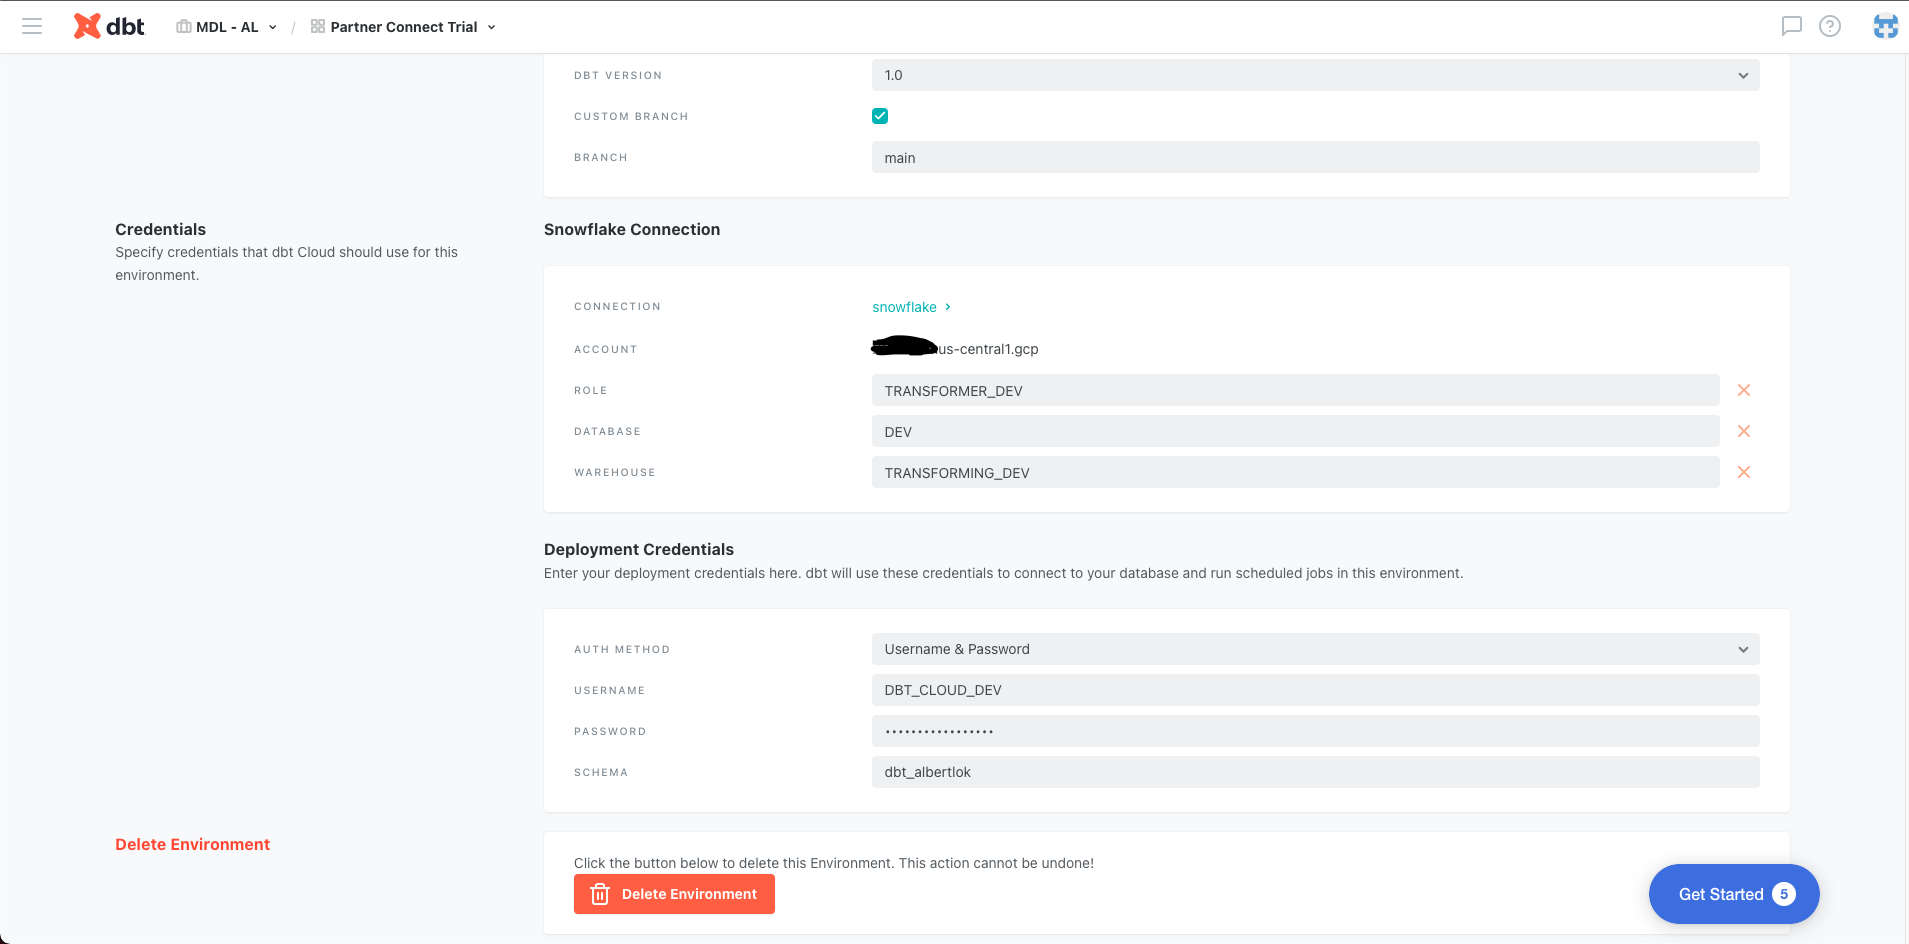

## STEP 4: Connection to GitHub

A custom branch, `main`, was created in the GitHub repository so that it wouldn't affect the master

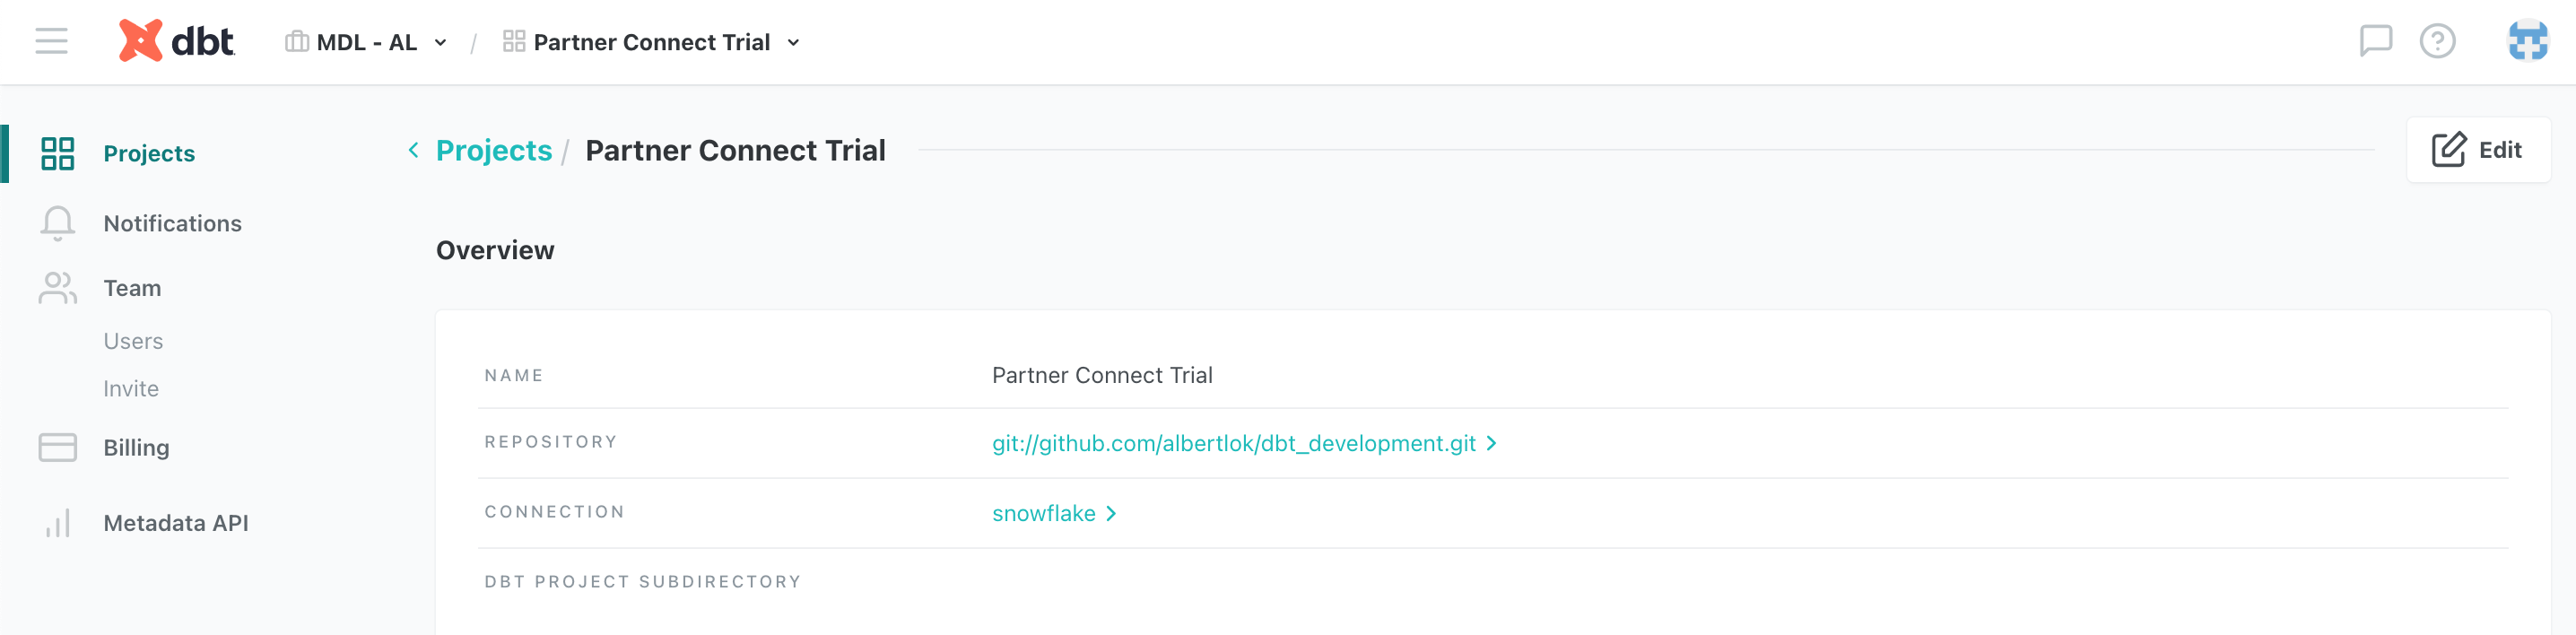


## STEP 5: Setup Continuous Integration
You can setup dbt cloud to run a CI job on every pull request into your `main` branch. After this, on every PR, dbt cloud will do the following:

1. Create a unique schema in your chosen environment. Schema name is determined by the PR id and prefixed with `dbt_cloud_pr_*`.
2. Create the models in the unique schema and run the defined tests.
3. After the run, add ✅ or ❌ indicator to the PR.

This CI feature allows us to test against the production data without actually creating production data assets. In order to leverage this feature, we need to create a job in the dbt cloud UI.

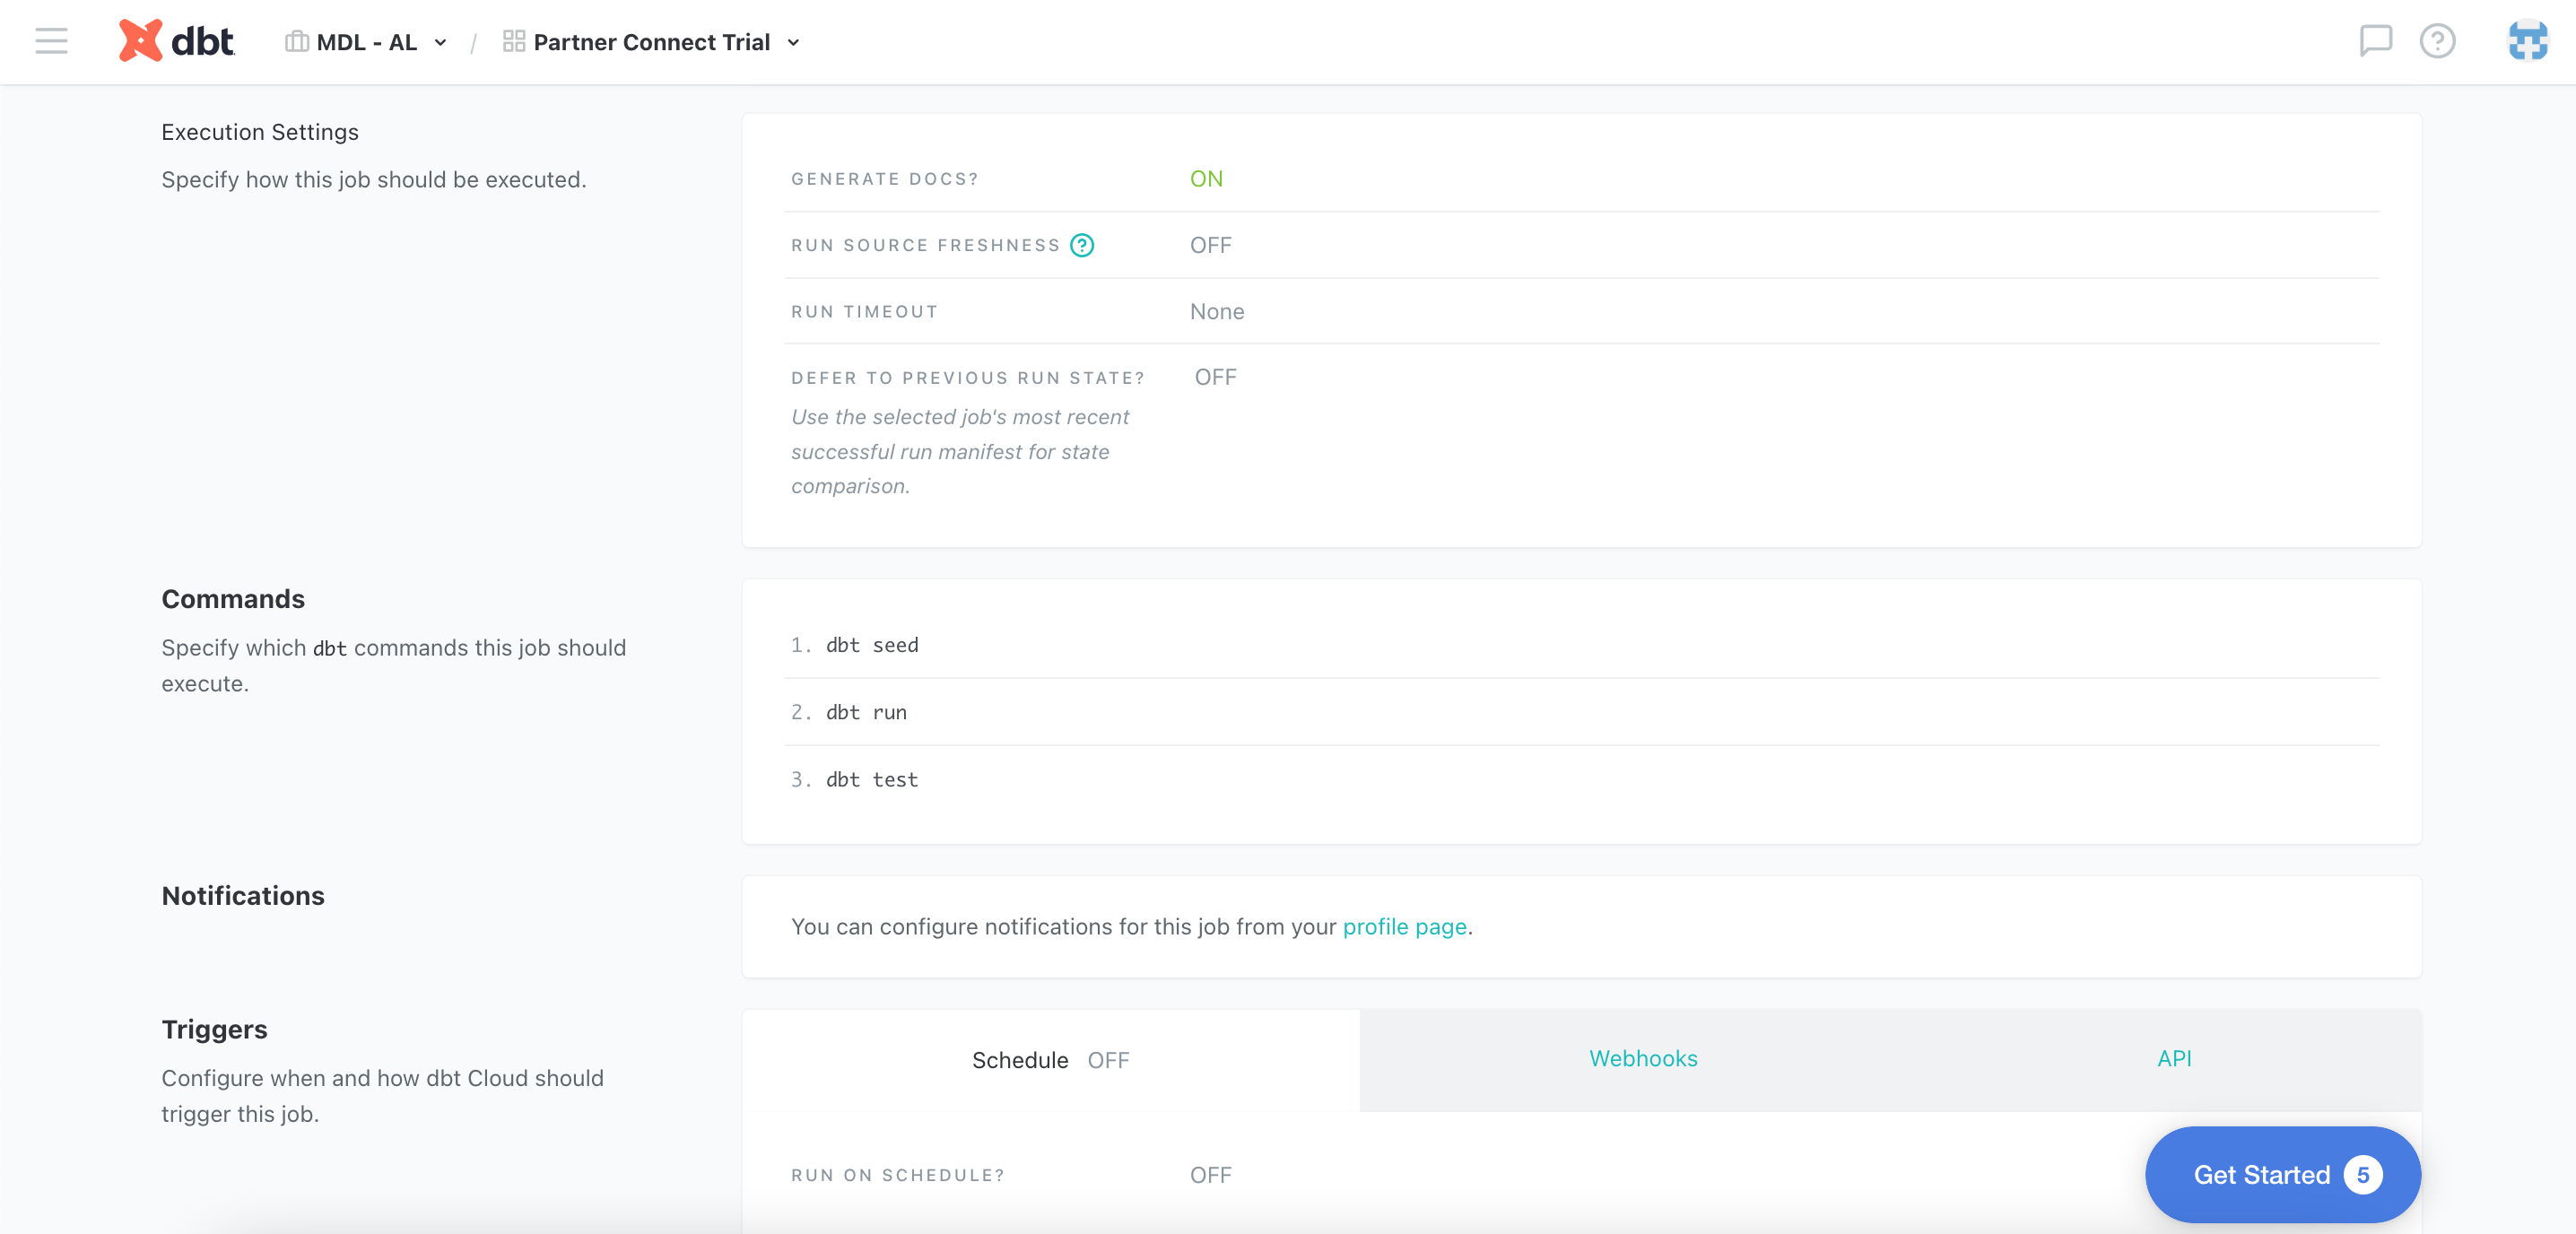

To test this, a git branch was created and my_first_dbt_model.sql was modified:
```
git checkout -b simple-test-branch
```

my_first_dbt_model.sql changes:
```
    select 1 as id
    union all
    select null as id
+   union all
+   select 2 as id
```

git commit and push:
```
git add models/example/my_first_dbt_model.sql
git commit -m 'simple model change'
git push -f origin simple-test-branch
```

## STEP 6: GitHub Pull Request

When you create a PR, a CI job is run and its status is added to your PR.  You can see the list of runs in the dbt UI under the respective job. In our case, it’s the CI job that we created in the previous section.

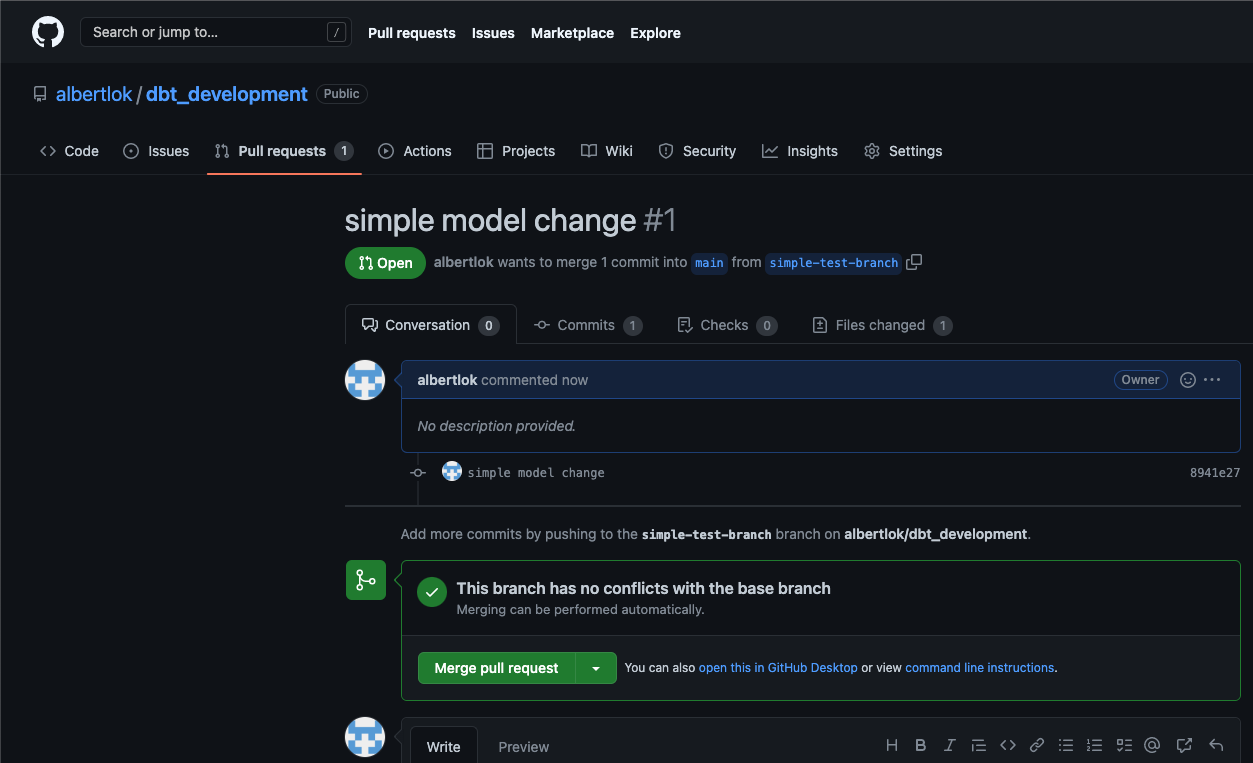

Note that this creates a temporary schema in your production database.

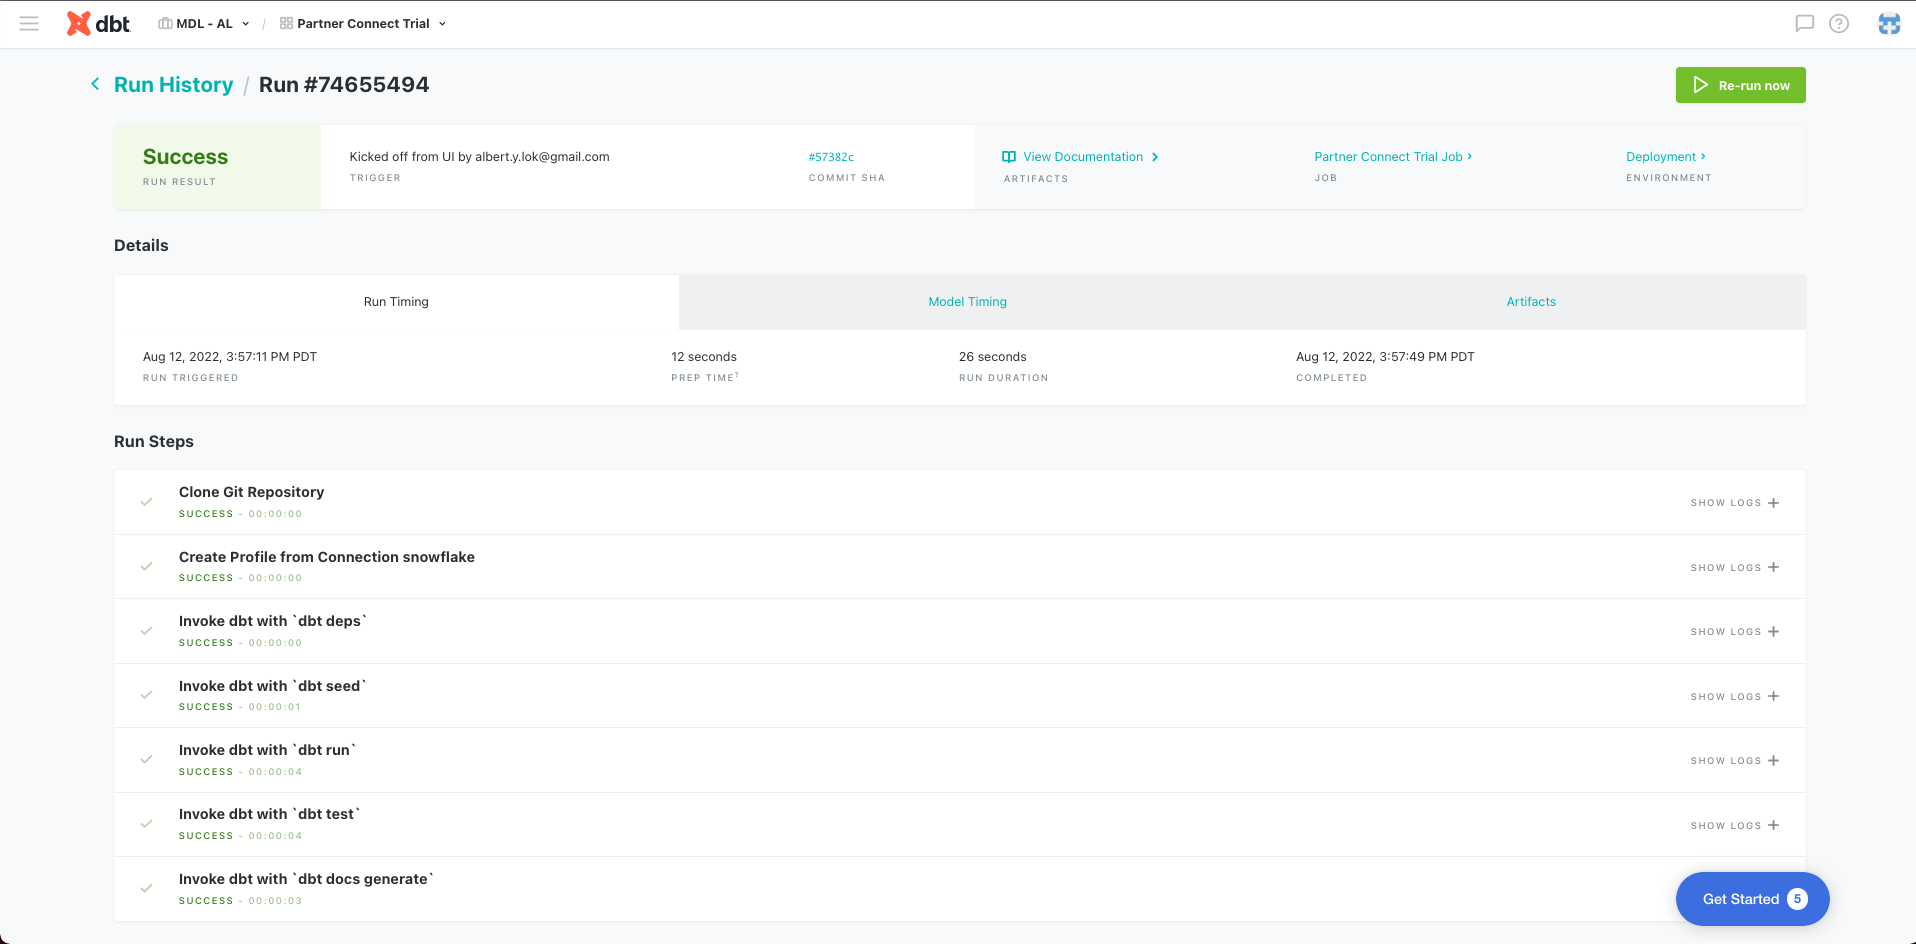

The data models are created in this schema. Dbt cloud runs tests on the data in this PR specific schema.

After the CI jobs pass, you can be confident that your code will work as expected on your current production data. You can merge your pull request.

## STEP 7

Now that our code is in production, we can start scheduling jobs. Dbt is a compiler and runner, but not a scheduler. This is where dbt cloud helps, by letting us schedule jobs with the required frequency.

![Schedule Jobs in dbt Cloud](https://www.startdataengineering.com/images/ci-dbt/dbt_job_1.png)

## STEP 8: Host Data Documentation

One of the most powerful features of dbt is its hosted documentation. Dbt allows us to specify column and table descriptions as part of your schema files. This documentation can be viewed by anyone with access to dbt cloud. We can generate documentation for any job from the project settings page. Dbt cloud will show the documentation from the latest run of the selected job.

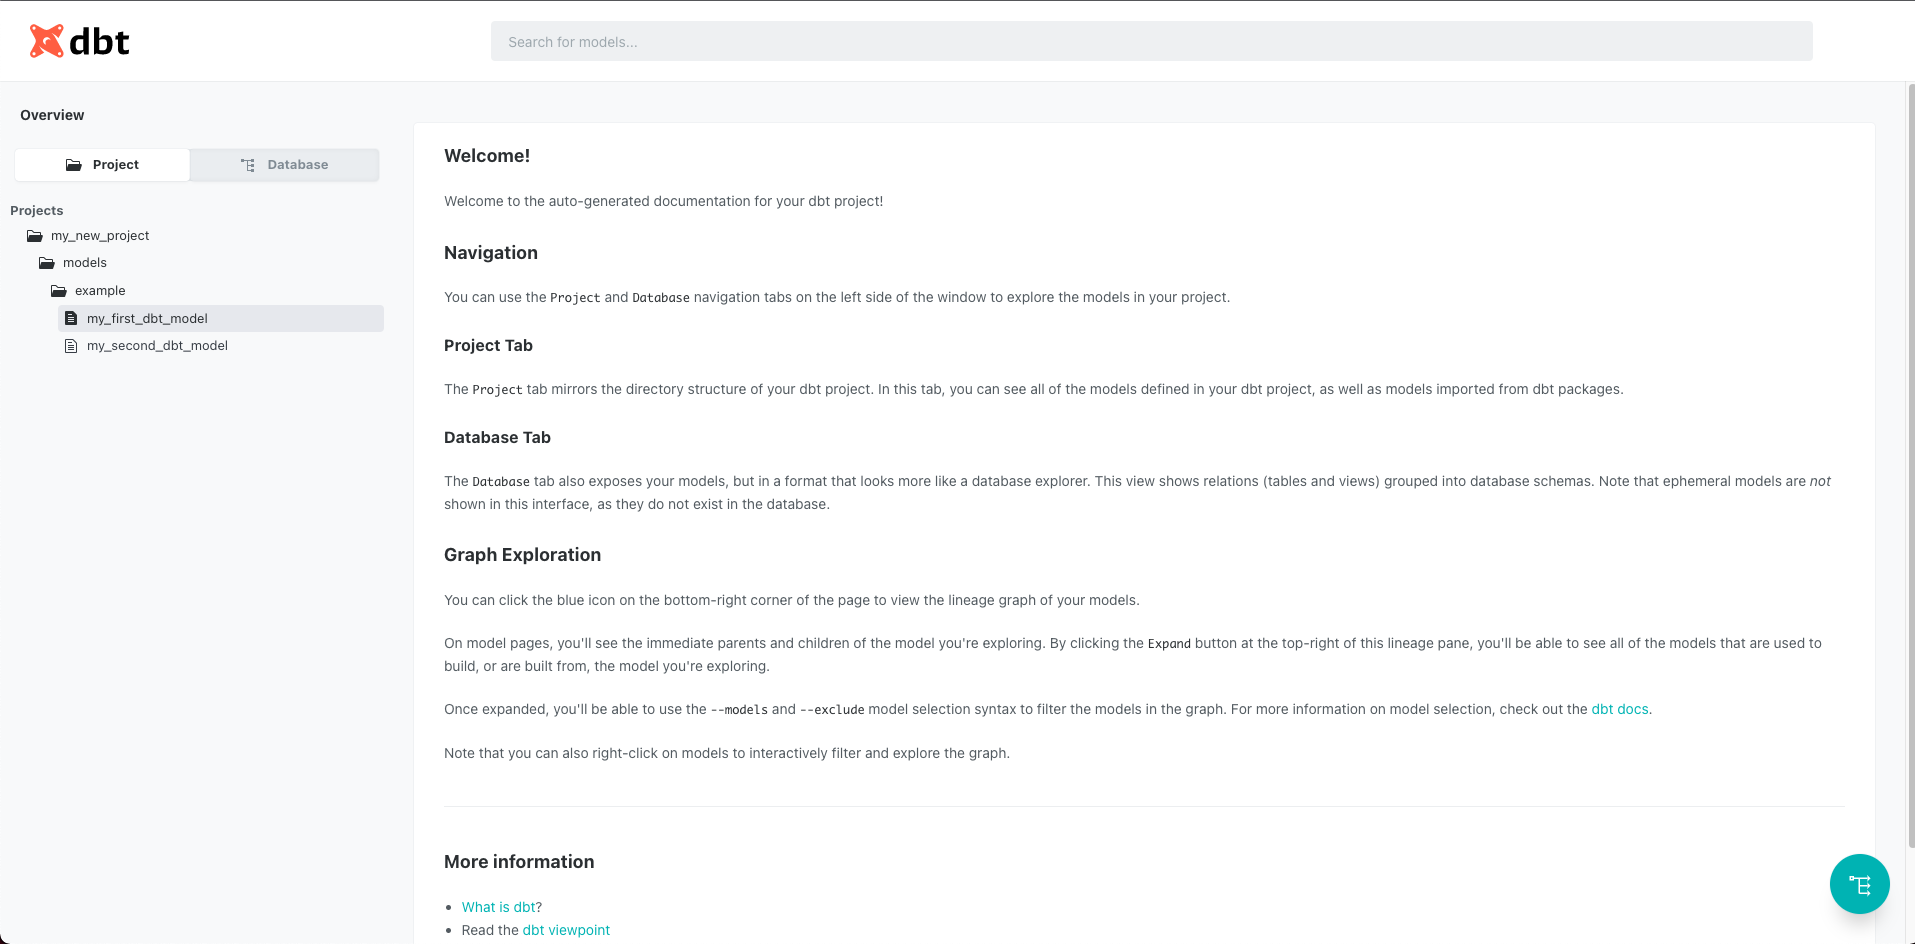

## CONCLUSION

In this project we practiced setting up an ETL data-ops workflow using dbt Cloud and Snowflake.

To summarize, we saw:
* How to setup Snowflake permissions for dbt cloud
* How to setup dbt cloud + github integration
* How to enable CI jobs on github PRs(Pull requests)
* How to schedule jobs from dbt cloud
* How to host documentation in dbt cloud